## imports:

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

#### defining graph parameters

In [2]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['font.size'] = 20

## loading base data

In [3]:
bike = pd.read_csv('bicicletas.csv')

## viewing database

In [4]:
bike.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
bike['datas'] = pd.to_datetime(bike['datas'])

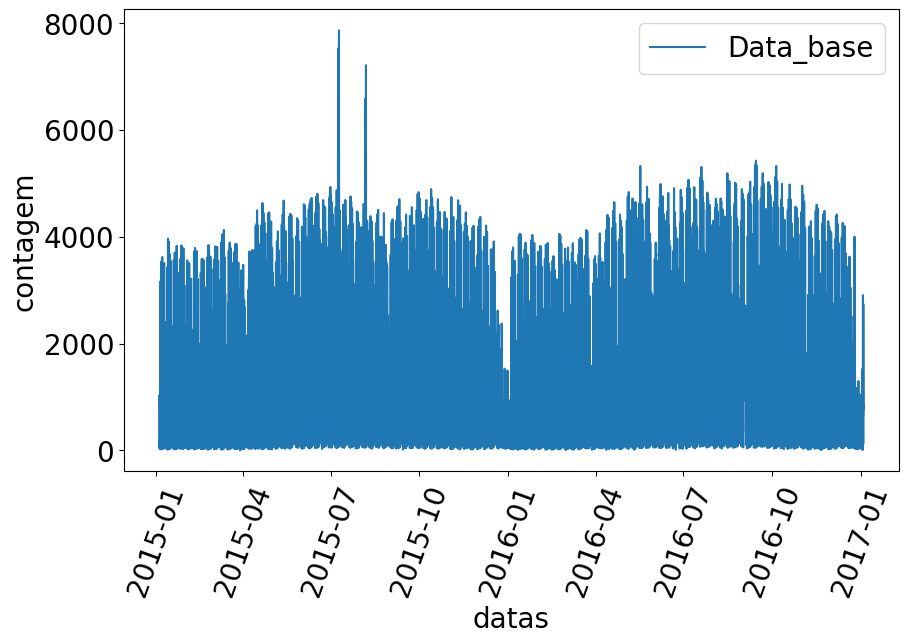

In [6]:
sns.lineplot(x='datas', y='contagem', data= bike, label='Data_base')
plt.xticks(rotation=70)
plt.show()

## preprocessing

In [7]:
bike_scaler =  StandardScaler()

In [8]:
y = bike_scaler.fit_transform(bike['contagem'].values.reshape(-1, 1))

In [9]:
y

array([[-0.88574518],
       [-0.9262953 ],
       [-0.92998167],
       ...,
       [-0.74289816],
       [-0.84703824],
       [-0.92537371]])

#### separating training base and test base

In [10]:
training_size = int(len(bike) * 0.9)
test_size = len(bike) - training_size

In [11]:
training_size, test_size

(15672, 1742)

In [12]:
y_training = y[0:training_size]
y_test = y[training_size:len(bike)]

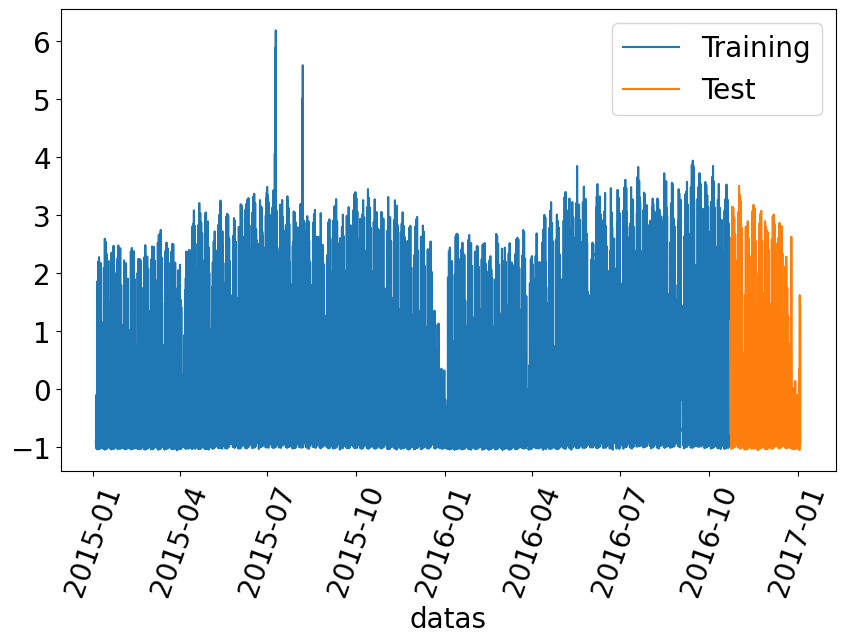

In [13]:
sns.lineplot(x='datas', y=y_training[:, 0], data=bike[0:training_size], label='Training')
sns.lineplot(x='datas', y=y_test[:, 0], data=bike[training_size:len(bike)], label='Test')
plt.xticks(rotation=70)
plt.show()

## changing data

#### creating function to define a delay in input data

In [14]:
def separate_data(vetor, n_steps):
    """Input: vector: number of passengers
                n_steps: number of steps in the regressor
      Exit:
               X_new: 2D Array
               y_novo: 1D Array - Our target
    """
    X_new, y_new = [], []
    for i in range(n_steps, vetor.shape[0]):
        X_new.append(list(vetor.loc[i - n_steps: i - 1]))
        y_new.append(vetor.loc[i])
    X_new, y_new = np.array(X_new), np.array(y_new)
    return X_new, y_new

In [15]:
vetor_training = pd.DataFrame(y_training)[0]
vetor_test = pd.DataFrame(y_test)[0]

In [16]:
X_training_steps10, y_training_steps10 = separate_data(vetor_training, 10)
X_test_steps10, y_test_steps10 = separate_data(vetor_test, 10)

## Adding 1 more dimension to the input base

In [17]:
X_training_steps10 = X_training_steps10.reshape(X_training_steps10.shape[0], X_training_steps10.shape[1], 1)

In [18]:
X_training_steps10.shape

(15662, 10, 1)

In [19]:
X_test_steps10 = X_test_steps10.reshape(X_test_steps10.shape[0], X_test_steps10.shape[1], 1)

In [20]:
X_test_steps10.shape

(1732, 10, 1)

In [21]:
X_training_steps10.shape[2]

1

## creating recurrent neural network LSTM

In [22]:
regressor_lstm = Sequential([
    LSTM(128, input_shape=(10, 1)),
    Dense(units=1)
])

### compiling

In [23]:
regressor_lstm.compile(loss='mean_squared_error', optimizer='RMSProp')

In [24]:
regressor_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = regressor_lstm.fit(X_training_steps10, y_training_steps10, validation_data=(X_test_steps10, y_test_steps10), epochs=100)

Epoch 1/100
490/490 [==============================] - 6s 8ms/step - loss: 0.2797 - val_loss: 0.0832
Epoch 2/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0824 - val_loss: 0.0465
Epoch 3/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0572 - val_loss: 0.0482
Epoch 4/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0485 - val_loss: 0.0282
Epoch 5/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0433 - val_loss: 0.0280
Epoch 6/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0409 - val_loss: 0.0268
Epoch 7/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0389 - val_loss: 0.0301
Epoch 8/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0374 - val_loss: 0.0219
Epoch 9/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0361 - val_loss: 0.0244
Epoch 10/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0353 - val_lo

In [26]:
y_pred_training = regressor_lstm(X_training_steps10)

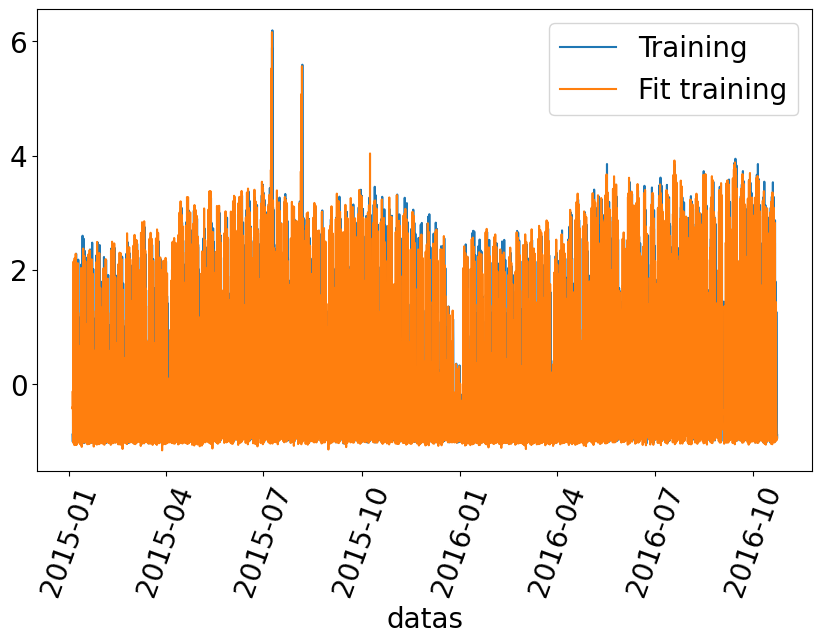

In [27]:
sns.lineplot(x='datas', y=y_training[:, 0], data=bike[0:training_size], label='Training')
sns.lineplot(x='datas', y=y_pred_training[:, 0], data=bike[0:len(y_training_steps10)], label='Fit training')
plt.xticks(rotation=70)
plt.show()

In [28]:
y_pred_test = regressor_lstm(X_test_steps10)

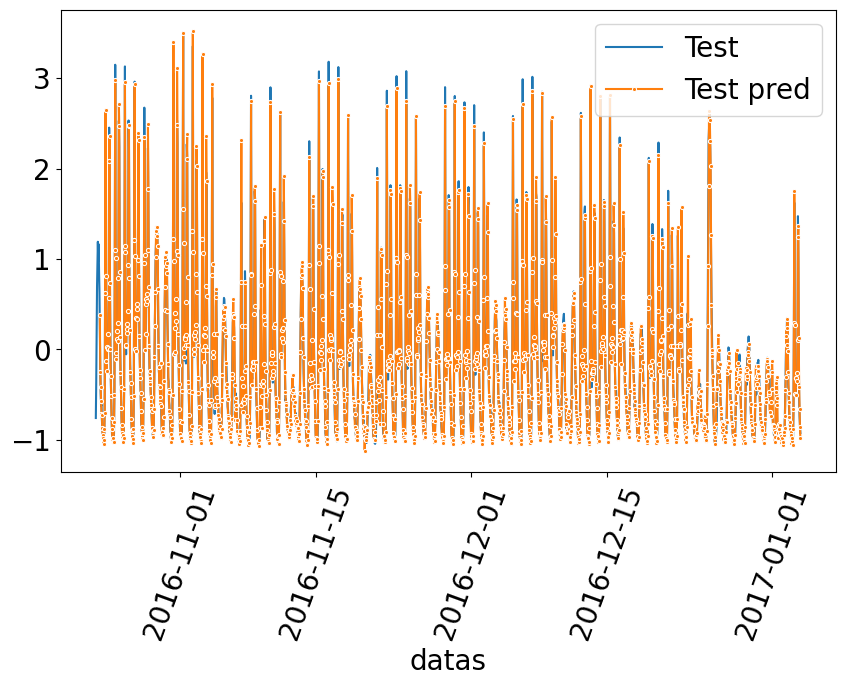

In [29]:
sns.lineplot(x='datas', y=y_test[:, 0], data=bike[training_size:len(bike)], label='Test')
sns.lineplot(x='datas', y=y_pred_test[:, 0], data=bike[training_size + 10: len(bike)], marker='.',label='Test pred')
plt.xticks(rotation=70)
plt.show()

## creating recurrent neural network GRU

In [30]:
regressor_gru = Sequential([
    GRU(128, input_shape=(10, 1)),
    Dense(units=1)
])

### compiling

In [31]:
regressor_gru.compile(loss='mean_squared_error', optimizer='RMSProp')

In [32]:
regressor_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history_gru = regressor_gru.fit(X_training_steps10, y_training_steps10, validation_data=(X_test_steps10, y_test_steps10), epochs=100)

Epoch 1/100
490/490 [==============================] - 5s 6ms/step - loss: 0.2344 - val_loss: 0.0786
Epoch 2/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0734 - val_loss: 0.0434
Epoch 3/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0523 - val_loss: 0.0305
Epoch 4/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0458 - val_loss: 0.0321
Epoch 5/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0410 - val_loss: 0.0509
Epoch 6/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0385 - val_loss: 0.0228
Epoch 7/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0364 - val_loss: 0.0247
Epoch 8/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0349 - val_loss: 0.0203
Epoch 9/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0338 - val_loss: 0.0218
Epoch 10/100
490/490 [==============================] - 3s 6ms/step - loss: 0.0324 - val_lo

In [34]:
y_pred_training_gru = regressor_gru(X_training_steps10)

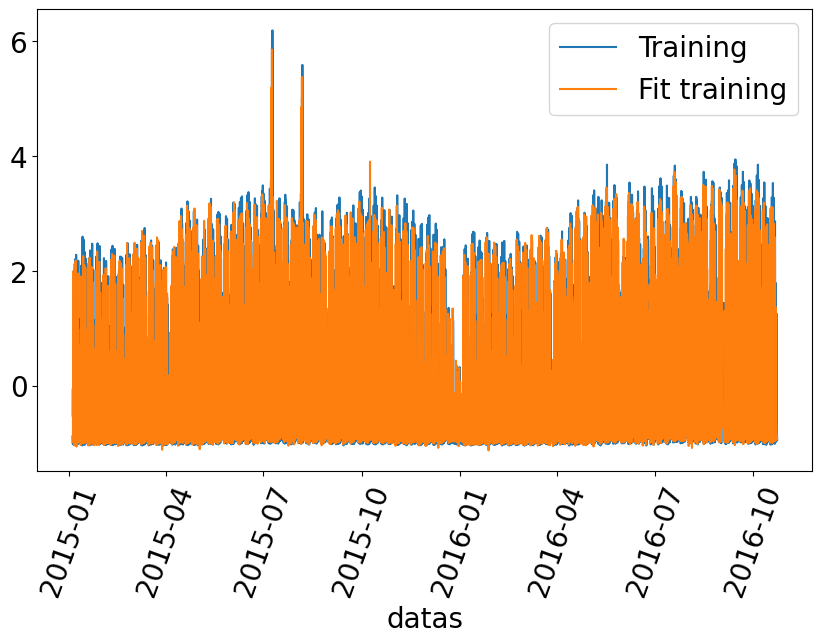

In [35]:
sns.lineplot(x='datas', y=y_training[:, 0], data=bike[0:training_size], label='Training')
sns.lineplot(x='datas', y=y_pred_training_gru[:, 0], data=bike[0:len(y_training_steps10)], label='Fit training')
plt.xticks(rotation=70)
plt.show()

In [36]:
y_pred_test_gru = regressor_gru(X_test_steps10)

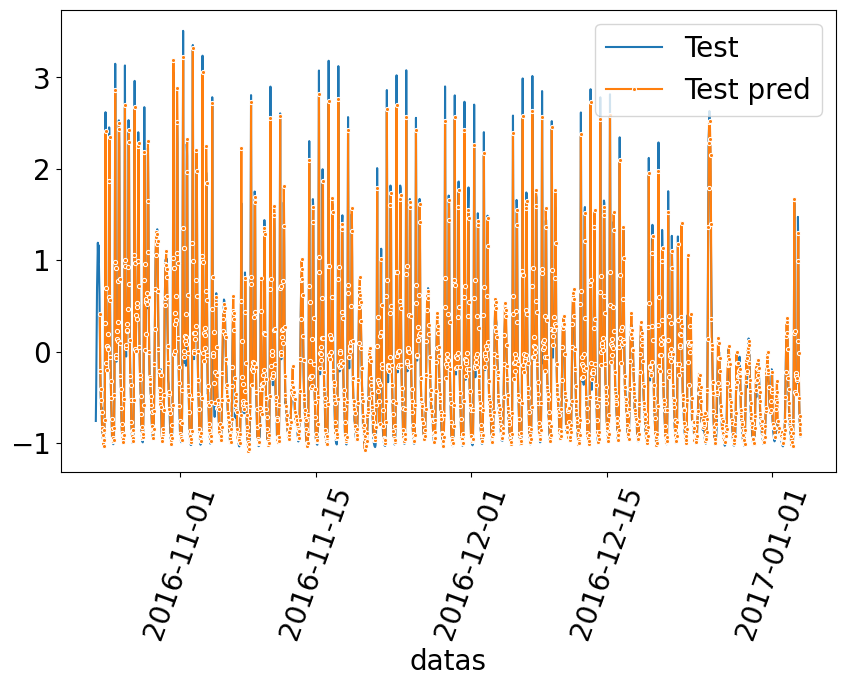

In [37]:
sns.lineplot(x='datas', y=y_test[:, 0], data=bike[training_size:len(bike)], label='Test')
sns.lineplot(x='datas', y=y_pred_test_gru[:, 0], data=bike[training_size + 10: len(bike)], marker='.',label='Test pred')
plt.xticks(rotation=70)
plt.show()

## comparing LSTM x GRU

In [38]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


## LSTM

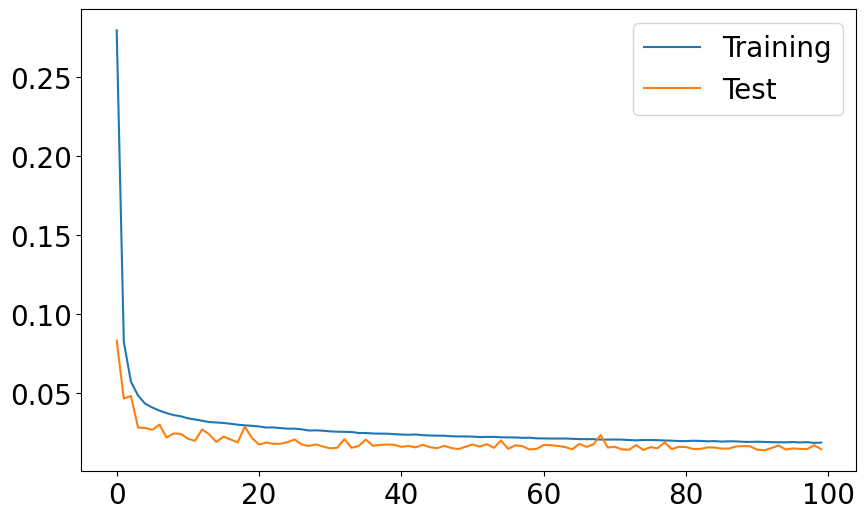

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Test'])

## GRU

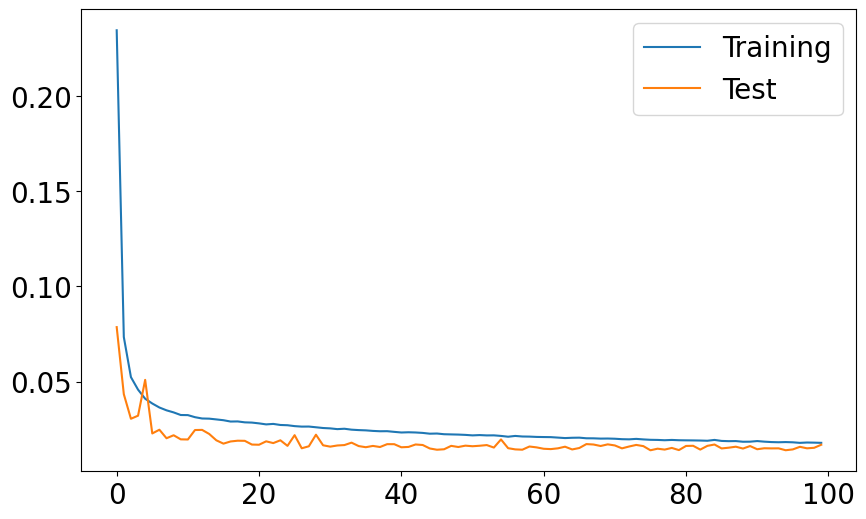

In [40]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.legend(['Training','Test'])